# DBSCAN (Clustering)
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that works better than k-means for nested clusters.

This is inspired by [StatQuest: Clustering with DBSCAN](https://youtu.be/RDZUdRSDOok)

## Hyperparameters heuristics

`epsilon`: One common approach is to use the k-distance graph to determine an appropriate value for epsilon. The idea is to plot the distance to the kth nearest neighbor for each point in the dataset and look for a knee or elbow point in the graph. This knee point can be a good estimate for epsilon.

`min_points`: A common rule of thumb is to set min_points to the dimensionality of your dataset plus one (min_points ≥ D + 1), where D is the number of features. However, you may need to adjust this based on the density and distribution of your data.

## Setup

In [93]:
import math
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib inline

## Fake data

In [94]:
torch.manual_seed(0xc0de)

n_cluster = 3
n_samples = 250
spacing = math.pi / 10 # spacing between arc clusters
center = torch.tensor([0., 0.])

def arc_cluster(angle_start, angle_end, radius=9, center=center, n_samples=n_samples):
    angle = torch.linspace(angle_start, angle_end, n_samples)
    x, y = torch.cos(angle), torch.sin(angle)
    noise = MultivariateNormal(center, torch.diag(torch.tensor([1., 1.]))).sample((n_samples,))
    xy = torch.stack([x, y], dim=1) * radius + noise
    return xy

clusters = []
# make a tiny cluster in the middle
clusters.append(MultivariateNormal(center, torch.diag(torch.tensor([5., 5.]))).sample((n_samples,)))
# make a half ring around the cluster
clusters.append(arc_cluster(0 + spacing, math.pi - spacing))
# and another half ring
clusters.append(arc_cluster(math.pi + spacing, 2 * math.pi - spacing))

data = torch.cat(clusters)

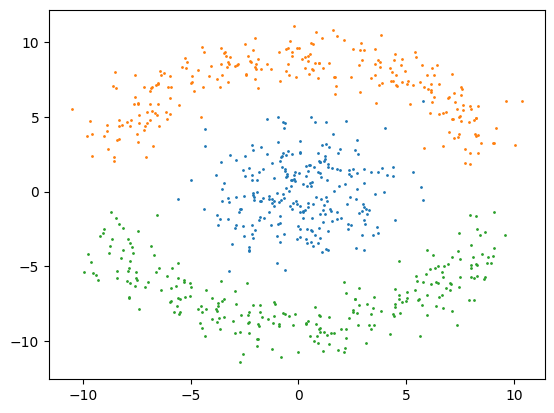

In [95]:
def plot_data(clusters, ax=None):
    if ax is None: _, ax = plt.subplots()
    for cluster in clusters:
        ax.scatter(cluster[:,0], cluster[:,1], s=1)

_ = plot_data(clusters)

## Code
Classify each points as `core point` if they have at least `min_points` within `epsilon` distance, and `non-core point` otherwise.

Pick a random `core point` to become a cluster, and recursively glue neighboring `core points` to it, an (non-recursively) glue `non-core points` to it.
Repeat until there's no `core point` unasigned.

In [96]:
# make a crappy hashable version of tensor because float precision keep biting me
def h(t):
    return f'{t}'

def dbscan(data, eps=1, min_points=4):
    # classify points as core or non-core
    core, non_core = [], set()
    for p in data:
        if (torch.norm(data - p, dim=1) < eps).sum() >= min_points:
            core.append(p)
        else:
            non_core.add(p)
    # build clusters
    seen = set()
    clusters = []
    while core:
        p = core.pop()
        if h(p) in seen: continue
        clusters.append([])
        q = [p]
        while q:
            p = q.pop()
            if h(p) in seen: continue
            seen.add(h(p))
            clusters[-1].append(p)
            if p in non_core: continue
            neighbors = data[(torch.norm(data - p, dim=1) < eps).nonzero().view(-1)]
            q.extend(neighbors)
        clusters[-1] = torch.stack(clusters[-1])
    return clusters

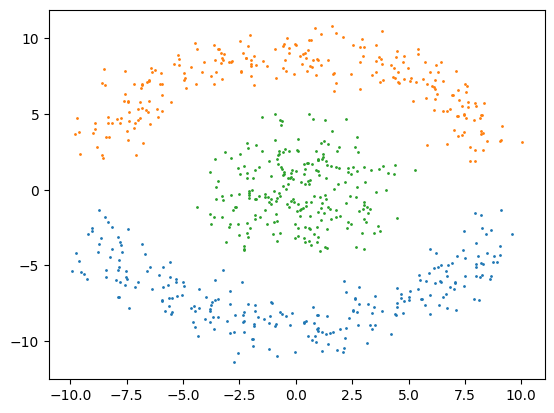

In [97]:
cs = dbscan(data)
_ = plot_data(cs)